# CS 6140 Machine Learning: Assignment - 2 (Total Points: 100)
## Prof. Ahmad Uzair





## Question 1 - Support Vector Machine and MLP  (30 points)



 In this problem you will be applying Support Vector Machine and Multi layer perceptron for binary classification.



You will train and test Support Vector Machine (SVM) and Multi-layer Perceptron (MLP) classifiers that aim for minimum probability of classification error. You may use any standard library of your choice. The SVM should use a Gaussian (radial-basis) kernel. The MLP should be a single-hidden layer model with your choice of activation functions for all perceptrons.

Generate 1000 independent and identically distributed (iid) samples for training and 5000 iid samples for testing. All data for class L ∈ {0, 1}, which are equiprobable and two dimensional, should be generated as follows:


x = r<sub>L</sub> * [cos(θ) sin(θ)]<sup>T</sup> + n

where,

 θ ∼ Uniform[−π, π],

 n ∼ N(0, σ<sup>2</sup>I), Note: N represents the Gaussian distribution 

 r<sub>0</sub> = 2, r<sub>1</sub> = 4, σ = 1


Note: The two class sample sets will be highly overlapping two concentric disks, and due to angular symmetry, we anticipate the best classification boundary to be a circle between the two disks. Your SVM and MLP models will try to approximate it.

Use the training data with 10-fold cross-validation to determine the best hyperparameters (box constraints parameter and Gaussian kernel width for the SVM, number of perceptrons in the hidden layer for the MLP). Once these hyperparameters are set, train your final SVM and MLP classifier using the entire training data set. Apply your trained SVM and MLP classifiers to the test data set and estimate the probability of error from this data set.

Show the following: 

(1) visual and numerical demonstrations of the K-fold cross-validation process indicating how the hyperparameters for SVM and MLP classifiers are set.

(2) visual and numerical demonstrations of the performance of your SVM and MLP classifiers on the test dataset.


Hint: For hyperparameter selection, you may show the performance estimates for various choices and indicate where the best result is achieved. For test performance, you may show the data and classification boundary superimposed, along with an estimated probability of error from the samples.


In [16]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

In [17]:
random.seed(8)

random_n = np.random.multivariate_normal([0, 0], np.identity(2), 6000)
random_theta = np.random.uniform(-np.pi, np.pi, 6000)
random_labels = np.random.randint(2, size = 6000)

fea = []
for i in range(6000):
    if random_labels[i] == 0:
        x = 2 * np.array([np.cos(random_theta[i]), np.sin(random_theta[i])]).T + random_n[i]
    else:
        x = 4 * np.array([np.cos(random_theta[i]), np.sin(random_theta[i])]).T + random_n[i]
    fea.append(x)

data = np.concatenate((np.array(fea), np.array([random_labels]).T), axis = 1)

df = pd.DataFrame(data, columns = ['x0', 'x1', 'Label'])

x_train, x_test, y_train, y_test = model_selection.train_test_split(df.iloc[:, : 2], df.iloc[:, 2], shuffle = False, train_size = 1000)

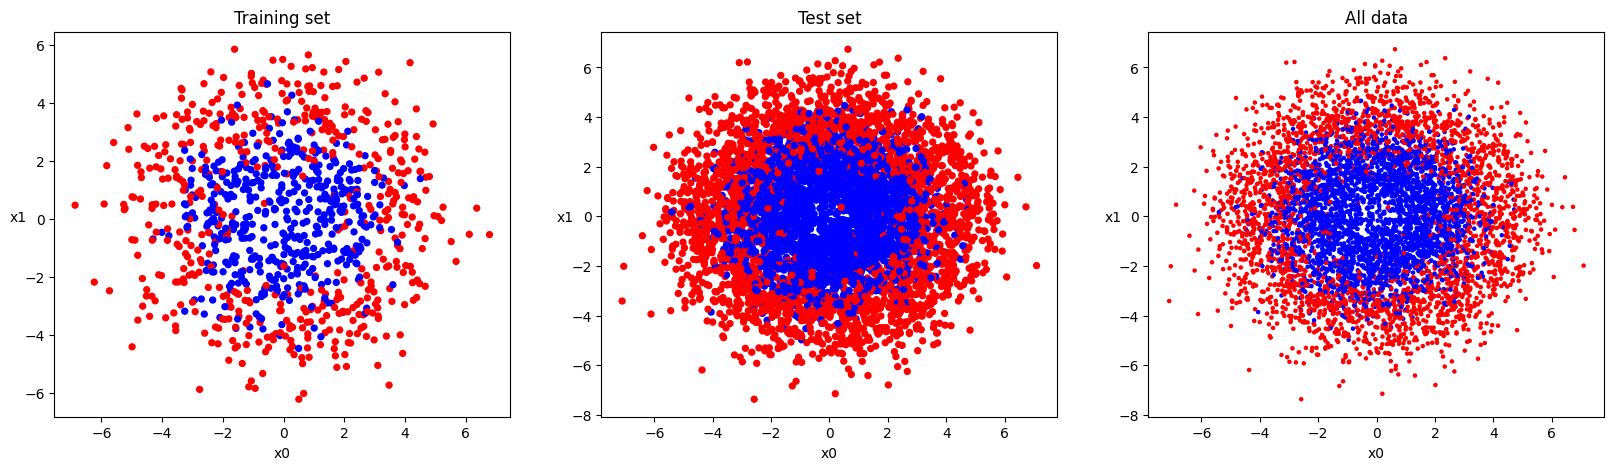

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 5))
ax1.scatter(x_train['x0'].values, x_train['x1'].values, s = 18, c = y_train.map(lambda t: 'r' if t == 1 else 'b'))
ax1.set_title('Training set')
ax1.set_xlabel('x0')
ax1.set_ylabel('x1', rotation='horizontal')

ax2.scatter(x_test['x0'].values, x_test['x1'].values, s = 18, c = y_test.map(lambda t: 'r' if t == 1 else 'b'))
ax2.set_title('Test set')
ax2.set_xlabel('x0')
ax2.set_ylabel('x1', rotation='horizontal')

ax3.scatter(df['x0'], df['x1'], s = 5, c = df['Label'].map(lambda t: 'r' if t == 1 else 'b'))
ax3.set_title('All data')
ax3.set_xlabel('x0')
ax3.set_ylabel('x1', rotation='horizontal')

plt.show()

## (1). Select Hyperparameters

In [19]:
def svc_param_selection(x_, y_, k_folds = 10):
    cs = [0.01, 0.1, 1, 10, 100]
    gammas = [0.01, 0.1, 1, 10]
    degrees = [3, 5, 7]
    param_grid = {'C': cs, 'degree': degrees, 'gamma': gammas}
    grid_search = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv = k_folds)
    grid_search.fit(x_, y_)

    params = list(zip(grid_search.cv_results_['params'], list(grid_search.cv_results_['mean_test_score'])))
    params.sort(key = lambda x: x[1], reverse = True)
    for i in params:
        print(i)

    return grid_search.best_params_, grid_search.best_score_, params

def mlp_param_selection(x_, y_, k_folds = 10):
    hidden_units = []
    for i in range(5, 101, 5):
        hidden_units.append((i, ))
    param_grid = {'hidden_layer_sizes': hidden_units, 'max_iter': [2000]}
    grid_search = model_selection.GridSearchCV(MLPClassifier(), param_grid, cv = k_folds)
    grid_search.fit(x_, y_)

    params = list(zip(grid_search.cv_results_['params'], list(grid_search.cv_results_['mean_test_score'])))
    params.sort(key = lambda x: x[1], reverse = True)
    for i in params:
        print(i)

    return grid_search.best_params_, grid_search.best_score_, params

In [20]:
def plot_boundary(model):
    x_min, x_max = -7, 7
    y_min, y_max = -7, 7
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,500),
                         np.linspace(y_min,y_max,500))
    print(xx.shape,yy.shape)
    print(np.c_[xx.flatten(), yy.flatten()].shape)  #(250000, 2)--->对应了网格点坐标矩阵中的每一个坐标点
    # 用训练好的分类器去预测各个坐标点中的数据的标签为[1]的值（其他为0）---全为1的位置就是决策边界
    z = model.predict(np.c_[xx.flatten(), yy.flatten()])    #z (250000,)
    print(z.shape)
    print(len(set(z)))
    zz = z.reshape(xx.shape)    #将我们预测出来的z值有一维空间，转换为二维网格坐标矩阵，便于在二维平面绘制决策边界
    plt.contour(xx, yy, zz, line = 2) #绘制决策边界 xx,yy是矩阵坐标，zz是我们对各个坐标的赋值，其中为1 的地方就是我们要找的决策边界
    # plt.contourf(xx, yy, zz, alpha = 0.8, color = ['g', 'b'])
    # plt.colorbar(contour_filled)

def plot_data(x_, y_, y_p):
    pos_x = np.array([x_[i] for i in range(len(y_)) if y_[i] == y_p[i]])
    neg_x = np.array([x_[i] for i in range(len(y_)) if y_[i] != y_p[i]])

    plt.scatter(pos_x[:,0], pos_x[:,1], c ='b', marker = 'o', s = 3, alpha = 0.5)
    plt.scatter(neg_x[:,0], neg_x[:,1], c ='r', marker = 'o', s = 3, alpha = 0.5)

#### Numerical results from hyperparameters of SVM

In [21]:
best_params_svm, best_score_svm, params_svm = svc_param_selection(x_train, y_train, 10)
print('Best Parameters for SVM: ', best_params_svm, end = '')
print(': ', best_score_svm)

({'C': 0.1, 'degree': 3, 'gamma': 0.1}, 0.8459999999999999)
({'C': 0.1, 'degree': 5, 'gamma': 0.1}, 0.8459999999999999)
({'C': 0.1, 'degree': 7, 'gamma': 0.1}, 0.8459999999999999)
({'C': 1, 'degree': 3, 'gamma': 0.1}, 0.845)
({'C': 1, 'degree': 5, 'gamma': 0.1}, 0.845)
({'C': 1, 'degree': 7, 'gamma': 0.1}, 0.845)
({'C': 100, 'degree': 3, 'gamma': 0.1}, 0.843)
({'C': 100, 'degree': 5, 'gamma': 0.1}, 0.843)
({'C': 100, 'degree': 7, 'gamma': 0.1}, 0.843)
({'C': 10, 'degree': 3, 'gamma': 0.01}, 0.842)
({'C': 10, 'degree': 5, 'gamma': 0.01}, 0.842)
({'C': 10, 'degree': 7, 'gamma': 0.01}, 0.842)
({'C': 100, 'degree': 3, 'gamma': 0.01}, 0.842)
({'C': 100, 'degree': 5, 'gamma': 0.01}, 0.842)
({'C': 100, 'degree': 7, 'gamma': 0.01}, 0.842)
({'C': 0.1, 'degree': 3, 'gamma': 1}, 0.841)
({'C': 0.1, 'degree': 5, 'gamma': 1}, 0.841)
({'C': 0.1, 'degree': 7, 'gamma': 1}, 0.841)
({'C': 10, 'degree': 3, 'gamma': 0.1}, 0.8400000000000001)
({'C': 10, 'degree': 5, 'gamma': 0.1}, 0.8400000000000001)
({'C':

#### Visual results from hyperparameters of SVM

In [25]:
def get_degree_gamma(d):
    C = []
    gamma = []
    sc = []
    for param, score in params_svm:
        if param['degree'] == d:
            C.append(param['C'])
            gamma.append(param['gamma'])
            sc.append(score)

    return np.array(C), np.array(gamma), np.array(sc)
d3_C, d3_gamma, d3_score = get_degree_gamma(3)
d5_C, d5_gamma, d5_score = get_degree_gamma(5)
d7_C, d7_gamma, d7_score = get_degree_gamma(7)

<class 'numpy.ndarray'> [ 0.1   0.1   0.1   0.01  0.01  1.    0.1   1.    0.01  0.01  1.   10.
  1.   10.   10.    0.1   0.01  1.   10.   10.  ] [0.846 0.845 0.843 0.842 0.842 0.841 0.84  0.838 0.836 0.834 0.823 0.81
 0.807 0.767 0.748 0.741 0.53  0.53  0.53  0.529]


#### Numerical results from hyperparameters of MLP

In [23]:
best_params_mlp, best_score_mlp = mlp_param_selection(x_train, y_train, 10)
print('Best Parameters for MLP: ', best_params_mlp, end = '')
print(': ', best_score_mlp)

({'hidden_layer_sizes': (60,), 'max_iter': 2000}, 0.8470000000000001)
({'hidden_layer_sizes': (45,), 'max_iter': 2000}, 0.8459999999999999)
({'hidden_layer_sizes': (5,), 'max_iter': 2000}, 0.844)
({'hidden_layer_sizes': (30,), 'max_iter': 2000}, 0.842)
({'hidden_layer_sizes': (80,), 'max_iter': 2000}, 0.842)
({'hidden_layer_sizes': (90,), 'max_iter': 2000}, 0.842)
({'hidden_layer_sizes': (100,), 'max_iter': 2000}, 0.842)
({'hidden_layer_sizes': (20,), 'max_iter': 2000}, 0.841)
({'hidden_layer_sizes': (40,), 'max_iter': 2000}, 0.841)
({'hidden_layer_sizes': (95,), 'max_iter': 2000}, 0.841)
({'hidden_layer_sizes': (65,), 'max_iter': 2000}, 0.8400000000000001)
({'hidden_layer_sizes': (70,), 'max_iter': 2000}, 0.8400000000000001)
({'hidden_layer_sizes': (75,), 'max_iter': 2000}, 0.8400000000000001)
({'hidden_layer_sizes': (85,), 'max_iter': 2000}, 0.8400000000000001)
({'hidden_layer_sizes': (15,), 'max_iter': 2000}, 0.8390000000000001)
({'hidden_layer_sizes': (35,), 'max_iter': 2000}, 0.83

ValueError: too many values to unpack (expected 2)

#### Performance of SVM on test set

In [ ]:
svm_clf = svm.SVC(kernel = 'rbf', C = best_params_svm['C'], degree = best_params_svm['degree'], gamma = best_params_svm['gamma'])
svm_clf.fit(x_train, y_train)
y_pred_svm = svm_clf.predict(x_test)
svm_acc = metrics.accuracy_score(y_pred_svm, y_test)
svm_mse = metrics.mean_squared_error(y_pred_svm, y_test)
print('Accuracy score: ', svm_acc)
print('MSE: ', svm_mse)

#### Performance of MLP on test set


In [ ]:
mlp_clf = MLPClassifier(hidden_layer_sizes = best_params_mlp['hidden_layer_sizes'], max_iter = 2000)
mlp_clf.fit(x_train, y_train)
y_pred_mlp = mlp_clf.predict(x_test)
mlp_acc = metrics.accuracy_score(y_pred_mlp, y_test)
mlp_mse = metrics.mean_squared_error(y_pred_mlp, y_test)
print('Accuracy score: ', mlp_acc)
print('MSE: ', mlp_mse)